In [19]:
p = [0.1,0.2,0.3]
K = [13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32]


In [20]:
# Cleaning the CSV File
import pandas as pd
import seaborn as sns

VTM = pd.read_csv("FME_Exponential_2.csv").fillna(0)

mask1 = VTM["type"] == "scalar"
mask2 = VTM["attrname"] == "iterationvarsd"
VTM1 = VTM[mask1]
VTM2 = VTM[mask2]
VTM = pd.concat([VTM1, VTM2])

VTM.to_csv("FME_Exponential_cleaned2.csv", index=False)


C:\Users\giova\AppData\Local\Temp\ipykernel_24616\3224038524.py:5: DtypeWarning: Columns (2,3,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  VTM = pd.read_csv("FME_Exponential_2.csv").fillna(0)


In [21]:

Q = []
for i in range(10):
    Q.append(f"Q{i}")

Q

['Q0', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9']

In [75]:
import re
q = re.findall(r'\d+', "asd2")
if q:
    print(q[0])

2


In [82]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import re

n = 50
C = 10
# p = p
# K = K
T = 9.26
t = 1/T
M = 30
sT = 3

VTM = pd.read_csv("FME_Exponential_cleaned2.csv").fillna(0)

configDetails = VTM[VTM["attrname"] == "iterationvarsd"]

VTM = VTM[VTM["type"] == "scalar"]

Exp_S = VTM[VTM["module"].str.contains("SuperMarket.checkout.localSink")]
Exp_S = Exp_S[Exp_S["name"] == "totalServiceTime:mean"]

Exp_TW = VTM[VTM["module"].str.contains("SuperMarket.globalSink")]
Exp_TW = Exp_TW[Exp_TW["name"] == "totalQueueingTime:mean"]

VTM = VTM[VTM["module"].str.contains("SuperMarket.checkout.queues")]
Exp_W = VTM[VTM["name"] == "queueingTime:mean"]

CSV = {
    "S": Exp_S,
    "W": Exp_W,
    "TW": Exp_TW    # Total Waiting Time
}

PI = {}

config = {}

for _, row in configDetails.iterrows():
    config[row["run"].split("-")[2]] = row["attrvalue"].replace("/", "_")


for key in CSV:
    PI[key] = {}
    for c in config:
        PI[key][config[c]] = {}
        for cc in config:
            PI[key][config[c]][cc] = {}
    for _, row in CSV[key].iterrows():
        run = row["run"].split("-")[2]
        q = re.findall(r'\d+', row["module"])
        if q:
            q = q[0]
            string = f"Q{q}"
            PI[key][config[run]][run][string] = row["value"] 
        else:
            PI[key][config[run]][run] = row["value"]

C = 10
PI_df = {}

Q = []
for i in range(C):
    Q.append(f"Q{i}")

for pi in PI:
    PI_df[pi] = {}
    for config in PI[pi]:
        if pi != "TW":
            PI_df[pi][config] = pd.DataFrame(columns=Q)
        else:
            PI_df[pi][config] = pd.DataFrame(columns=["GS"])

for pi in PI:
    for config in PI[pi]:
        for run in PI[pi][config]:
            # Check if PI[pi][config][run] != {}
            if PI[pi][config][run]:
                # Check if PI[pi][config][run] is a dictionary
                if isinstance(PI[pi][config][run], dict):
                    for q in PI[pi][config][run]:
                        PI_df[pi][config].loc[int(run), q] = PI[pi][config][run][q]
                else:
                    PI_df[pi][config].loc[int(run)] = PI[pi][config][run]

        PI_df[pi][config] = PI_df[pi][config].sort_index()
        PI_df[pi][config] = PI_df[pi][config].reset_index(drop=True)


# E[W] = E[R]- E[t_S]
# E[R] = E[W] + E[t_S]
    
PI_df["R"] = {}
for config in PI_df["W"]:
    PI_df["R"][config] = PI_df["W"][config] + PI_df["S"][config]
    
PI_ME = {
    "R": {},
    "W": {}
}

couples = [f"{a}_{b}"  for a in p for b in K]

for key in PI_ME:
    for couple in couples:
        PI_ME[key][couple] = {}
        PI_ME[key][couple]["mean"] = PI_df[key][couple].mean()
        PI_ME[key][couple]["std"] = PI_df[key][couple].std()




C:\Users\giova\AppData\Local\Temp\ipykernel_24616\1526374091.py:17: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  VTM = pd.read_csv("FME_Exponential_cleaned2.csv").fillna(0)


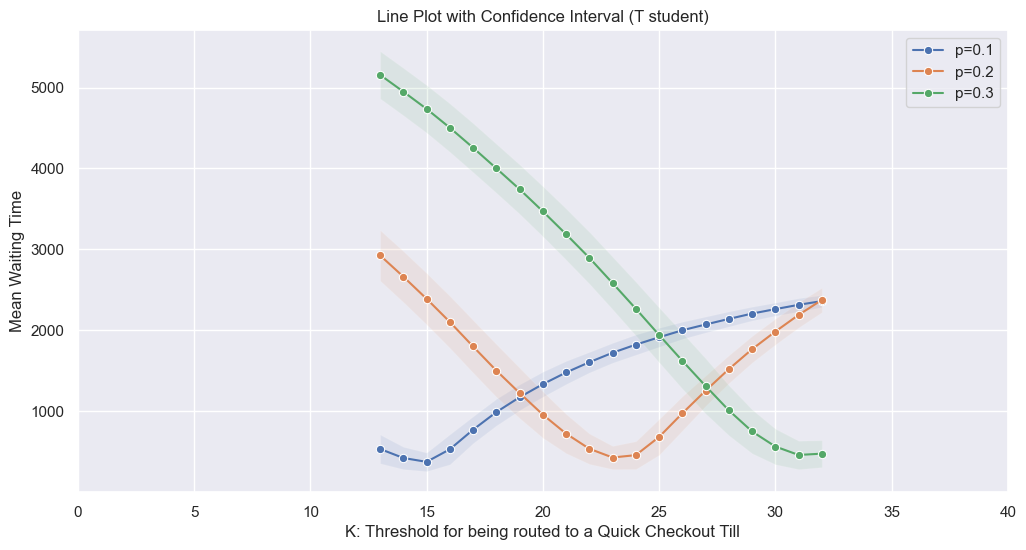

In [92]:
sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

# Ma il mean delle diverse code è uguale al service time del global???
# Provare direttamente a dare tutti i valori a lineplot perché si calcola direttamente il CI
# A questo punto scartare 0.4 e 0.5 e investigare sugli altri ed aumentare K

pi = "W"

for p_ in p:

    y_W = []
    ci_lb = []
    ci_ub = []
    for k in K:
        couple = f"{p_}_{k}"
        
        y_W.append(PI_ME[pi][couple]["mean"].mean())
        sigma = math.sqrt((PI_ME[pi][couple]["std"]**2).sum() / C)
        # print(sigma, PI_ME[pi][couple]["mean"].std())
        ci_lb.append(PI_ME[pi][couple]["mean"].mean() - (1.833 * (sigma / math.sqrt(len(PI_ME[pi][couple]["mean"])))))
        ci_ub.append(PI_ME[pi][couple]["mean"].mean() + (1.833 * (sigma / math.sqrt(len(PI_ME[pi][couple]["mean"])))))
        # See also: https://stats.stackexchange.com/questions/12002/how-to-calculate-the-confidence-interval-of-the-mean-of-means

    plt.fill_between(K, ci_lb, ci_ub, alpha=0.1)
    sns.lineplot(x=K, y=y_W, marker='o', label=f"p={p_}")


plt.xlim(0, 40)  # Set the x-axis limits
# plt.ylim(200, 600)  # Set the y-axis limits
plt.title('Line Plot with Confidence Interval (T student)')
plt.xlabel('K: Threshold for being routed to a Quick Checkout Till')
plt.ylabel('Mean Waiting Time')

plt.legend()
plt.show()

In [47]:
PI_df["W"]["0.1_13"]["Q0"]

0     40.912165
1     41.661076
2     37.286298
3     41.522099
4     46.602494
5     71.218899
6     53.155503
7     45.116703
8     41.132273
9     40.876946
10    40.836448
11    39.260316
12    31.099577
13    34.984104
14    35.763104
15     43.19117
16     48.83469
17    42.533705
18    36.573309
19    39.230016
20    41.614113
21    34.083267
22     40.46263
23    48.591082
24    35.601973
25    43.533459
26    38.900226
27    51.102205
28    56.679757
29    39.356033
30    52.584509
31    44.998439
32    39.733085
33    54.715478
34    34.484891
35    31.853697
36    35.980368
37    39.832617
38    44.103067
39    38.624173
40    40.999237
41    35.131638
42    49.208714
43    40.373758
44    44.311371
45    49.318806
46    59.055663
47    44.751375
48    42.705606
49    48.025811
Name: Q0, dtype: object

In [85]:
PI_df[pi][couple]["GS"].mean()

8994.56713630249

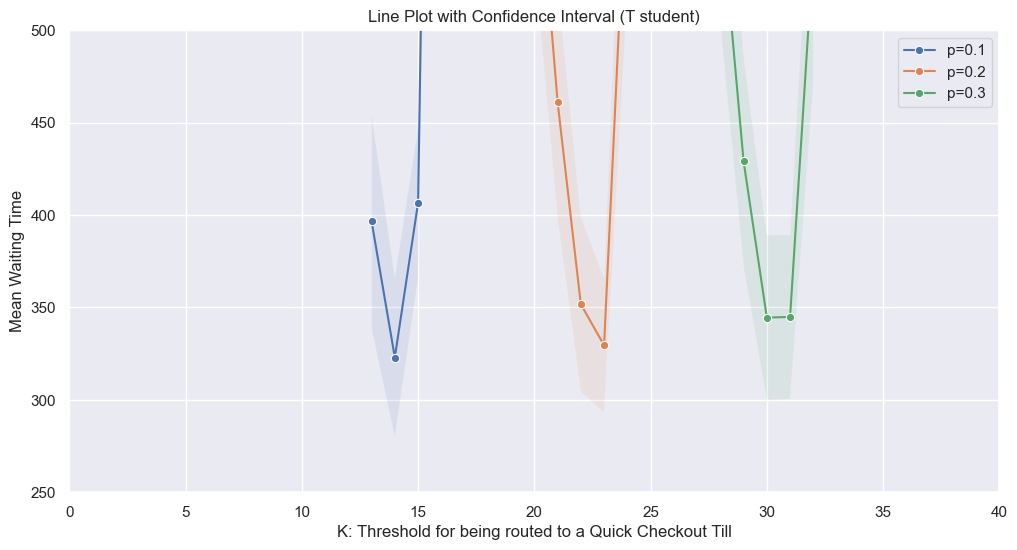

In [93]:
# Total Waiting Time (Global Sink)

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

# Ma il mean delle diverse code è uguale al service time del global???
# Provare direttamente a dare tutti i valori a lineplot perché si calcola direttamente il CI
# A questo punto scartare 0.4 e 0.5 e investigare sugli altri ed aumentare K

pi = "TW"

for p_ in p:

    y_W = []
    ci_lb = []
    ci_ub = []
    for k in K:
        couple = f"{p_}_{k}"
        
        y_W.append(PI_df[pi][couple]["GS"].mean())

        ci_lb.append(PI_df[pi][couple]["GS"].mean() - (1.96 * (PI_df[pi][couple]["GS"].std() / math.sqrt(n))))
        ci_ub.append(PI_df[pi][couple]["GS"].mean() + (1.96 * (PI_df[pi][couple]["GS"].std() / math.sqrt(n))))
        # See also: https://stats.stackexchange.com/questions/12002/how-to-calculate-the-confidence-interval-of-the-mean-of-means

    plt.fill_between(K, ci_lb, ci_ub, alpha=0.1)
    sns.lineplot(x=K, y=y_W, marker='o', label=f"p={p_}")


plt.xlim(0, 40)  # Set the x-axis limits
plt.ylim(250, 500)  # Set the y-axis limits
plt.title('Line Plot with Confidence Interval (T student)')
plt.xlabel('K: Threshold for being routed to a Quick Checkout Till')
plt.ylabel('Mean Waiting Time')

plt.legend()
plt.show()

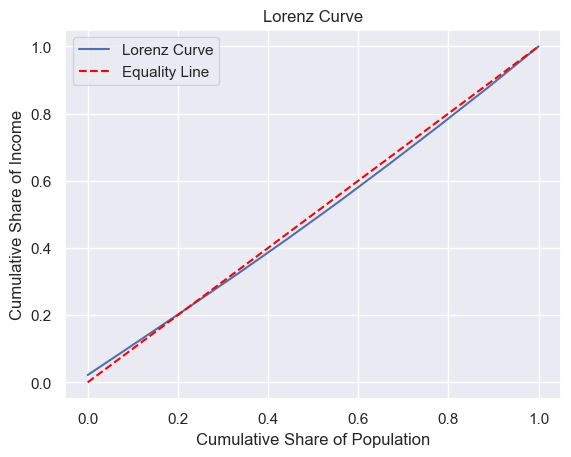

In [117]:
# Cosiderare ache il comportamento delle singole code
# Plottare intervallo relativo al CI della configurazione senza code veloci
# Investigare ulteriormente su discorso della fairness: Lorenz Curve.


import matplotlib.pyplot as plt
import numpy as np

# Sample data representing income distribution (sorted in ascending order)
income_data = np.array(sorted(PI_df["W"]["0.1_14"].mean().values.tolist()))

# Calculate cumulative share of income
cumulative_income_share = np.cumsum(income_data) / np.sum(income_data)

# Create Lorenz curve points
lorenz_curve = np.column_stack((np.linspace(0, 1, len(cumulative_income_share)), cumulative_income_share))

# Plot the Lorenz curve
plt.plot(lorenz_curve[:, 0], lorenz_curve[:, 1], label='Lorenz Curve')

# Plot the equality line (45-degree line)
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Equality Line')

# Add labels and title
plt.xlabel('Cumulative Share of Population')
plt.ylabel('Cumulative Share of Income')
plt.title('Lorenz Curve')

# Add legend
plt.legend()

# Show the plot
plt.show()



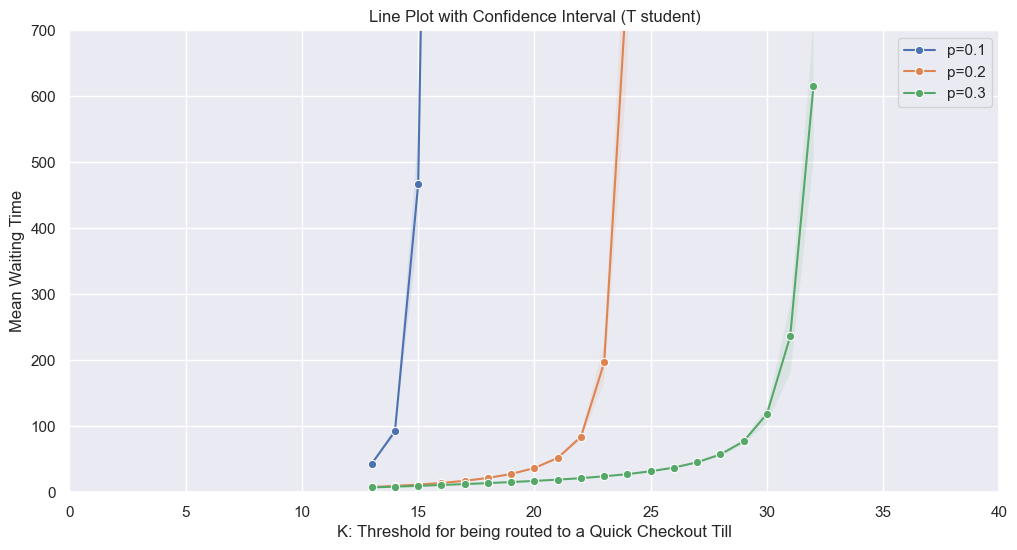

In [58]:
# Single Queue

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

# Ma il mean delle diverse code è uguale al service time del global???
# Provare direttamente a dare tutti i valori a lineplot perché si calcola direttamente il CI
# A questo punto scartare 0.4 e 0.5 e investigare sugli altri ed aumentare K

pi = "W"

for p_ in p:

    y_W = []
    ci_lb = []
    ci_ub = []
    for k in K:
        couple = f"{p_}_{k}"
        
        y_W.append(PI_df[pi][couple]["Q0"].mean())

        ci_lb.append(PI_df[pi][couple]["Q0"].mean() - (1.96 * (PI_df[pi][couple]["Q0"].std() / math.sqrt(n))))
        ci_ub.append(PI_df[pi][couple]["Q0"].mean() + (1.96 * (PI_df[pi][couple]["Q0"].std() / math.sqrt(n))))
        # See also: https://stats.stackexchange.com/questions/12002/how-to-calculate-the-confidence-interval-of-the-mean-of-means

    plt.fill_between(K, ci_lb, ci_ub, alpha=0.1)
    sns.lineplot(x=K, y=y_W, marker='o', label=f"p={p_}")


plt.xlim(0, 40)  # Set the x-axis limits
plt.ylim(0, 700)  # Set the y-axis limits
plt.title('Line Plot with Confidence Interval (T student)')
plt.xlabel('K: Threshold for being routed to a Quick Checkout Till')
plt.ylabel('Mean Waiting Time')

plt.legend()
plt.show()

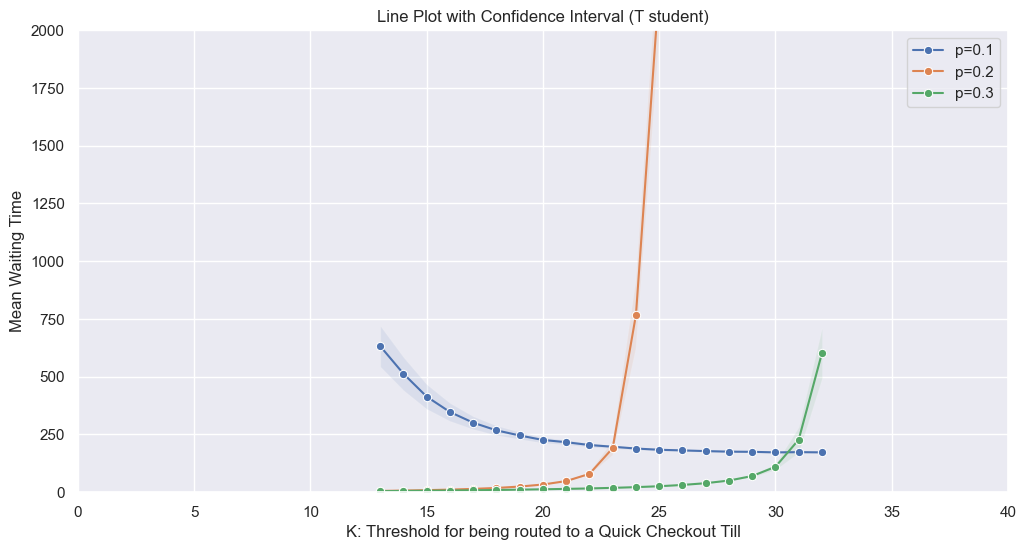

In [55]:
# Single Queue

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

# Ma il mean delle diverse code è uguale al service time del global???
# Provare direttamente a dare tutti i valori a lineplot perché si calcola direttamente il CI
# A questo punto scartare 0.4 e 0.5 e investigare sugli altri ed aumentare K

pi = "W"

for p_ in p:

    y_W = []
    ci_lb = []
    ci_ub = []
    for k in K:
        couple = f"{p_}_{k}"
        
        y_W.append(PI_df[pi][couple]["Q1"].mean())

        ci_lb.append(PI_df[pi][couple]["Q1"].mean() - (1.96 * (PI_df[pi][couple]["Q1"].std() / math.sqrt(n))))
        ci_ub.append(PI_df[pi][couple]["Q1"].mean() + (1.96 * (PI_df[pi][couple]["Q1"].std() / math.sqrt(n))))
        # See also: https://stats.stackexchange.com/questions/12002/how-to-calculate-the-confidence-interval-of-the-mean-of-means

    plt.fill_between(K, ci_lb, ci_ub, alpha=0.1)
    sns.lineplot(x=K, y=y_W, marker='o', label=f"p={p_}")


plt.xlim(0, 40)  # Set the x-axis limits
plt.ylim(0, 2000)  # Set the y-axis limits
plt.title('Line Plot with Confidence Interval (T student)')
plt.xlabel('K: Threshold for being routed to a Quick Checkout Till')
plt.ylabel('Mean Waiting Time')

plt.legend()
plt.show()

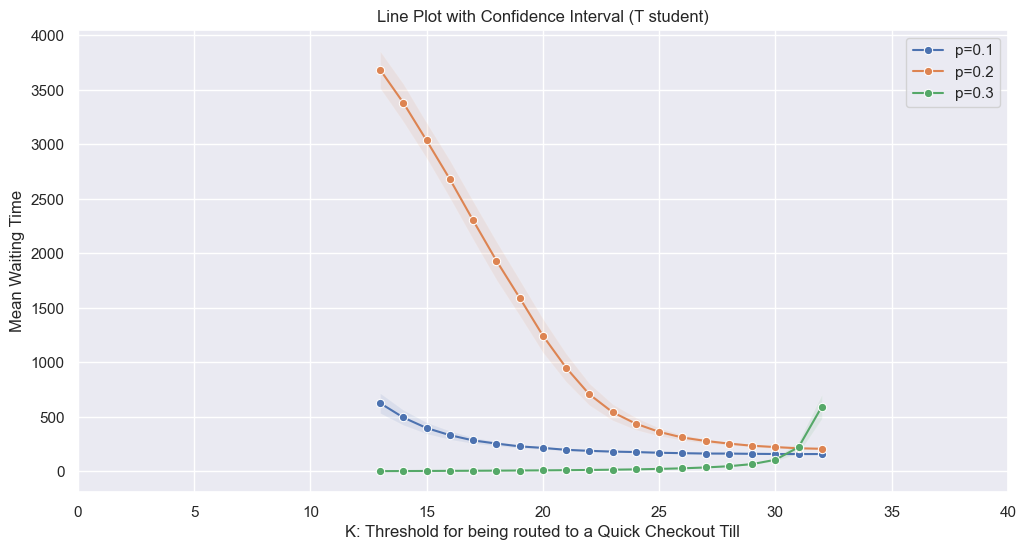

In [59]:
# Single Queue

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

# Ma il mean delle diverse code è uguale al service time del global???
# Provare direttamente a dare tutti i valori a lineplot perché si calcola direttamente il CI
# A questo punto scartare 0.4 e 0.5 e investigare sugli altri ed aumentare K

pi = "W"

for p_ in p:

    y_W = []
    ci_lb = []
    ci_ub = []
    for k in K:
        couple = f"{p_}_{k}"
        
        y_W.append(PI_df[pi][couple]["Q2"].mean())

        ci_lb.append(PI_df[pi][couple]["Q2"].mean() - (1.96 * (PI_df[pi][couple]["Q2"].std() / math.sqrt(n))))
        ci_ub.append(PI_df[pi][couple]["Q2"].mean() + (1.96 * (PI_df[pi][couple]["Q2"].std() / math.sqrt(n))))
        # See also: https://stats.stackexchange.com/questions/12002/how-to-calculate-the-confidence-interval-of-the-mean-of-means

    plt.fill_between(K, ci_lb, ci_ub, alpha=0.1)
    sns.lineplot(x=K, y=y_W, marker='o', label=f"p={p_}")


plt.xlim(0, 40)  # Set the x-axis limits
# plt.ylim(0, 2000)  # Set the y-axis limits
plt.title('Line Plot with Confidence Interval (T student)')
plt.xlabel('K: Threshold for being routed to a Quick Checkout Till')
plt.ylabel('Mean Waiting Time')

plt.legend()
plt.show()

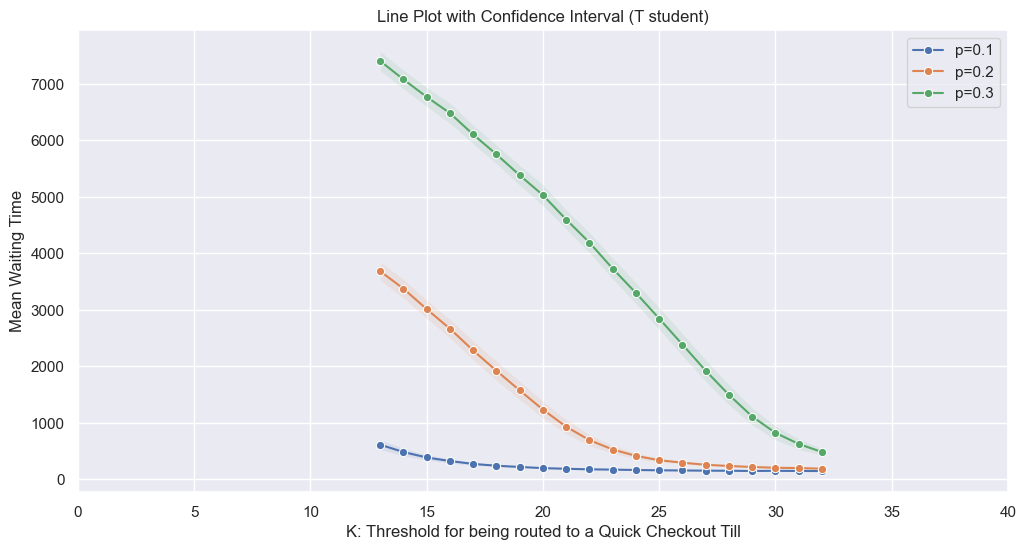

In [63]:
# Single Queue

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

# Ma il mean delle diverse code è uguale al service time del global???
# Provare direttamente a dare tutti i valori a lineplot perché si calcola direttamente il CI
# A questo punto scartare 0.4 e 0.5 e investigare sugli altri ed aumentare K

pi = "W"

for p_ in p:

    y_W = []
    ci_lb = []
    ci_ub = []
    for k in K:
        couple = f"{p_}_{k}"
        
        y_W.append(PI_df[pi][couple]["Q3"].mean())

        ci_lb.append(PI_df[pi][couple]["Q3"].mean() - (1.96 * (PI_df[pi][couple]["Q3"].std() / math.sqrt(n))))
        ci_ub.append(PI_df[pi][couple]["Q3"].mean() + (1.96 * (PI_df[pi][couple]["Q3"].std() / math.sqrt(n))))
        # See also: https://stats.stackexchange.com/questions/12002/how-to-calculate-the-confidence-interval-of-the-mean-of-means

    plt.fill_between(K, ci_lb, ci_ub, alpha=0.1)
    sns.lineplot(x=K, y=y_W, marker='o', label=f"p={p_}")


plt.xlim(0, 40)  # Set the x-axis limits
# plt.ylim(0, 500)  # Set the y-axis limits
plt.title('Line Plot with Confidence Interval (T student)')
plt.xlabel('K: Threshold for being routed to a Quick Checkout Till')
plt.ylabel('Mean Waiting Time')

plt.legend()
plt.show()

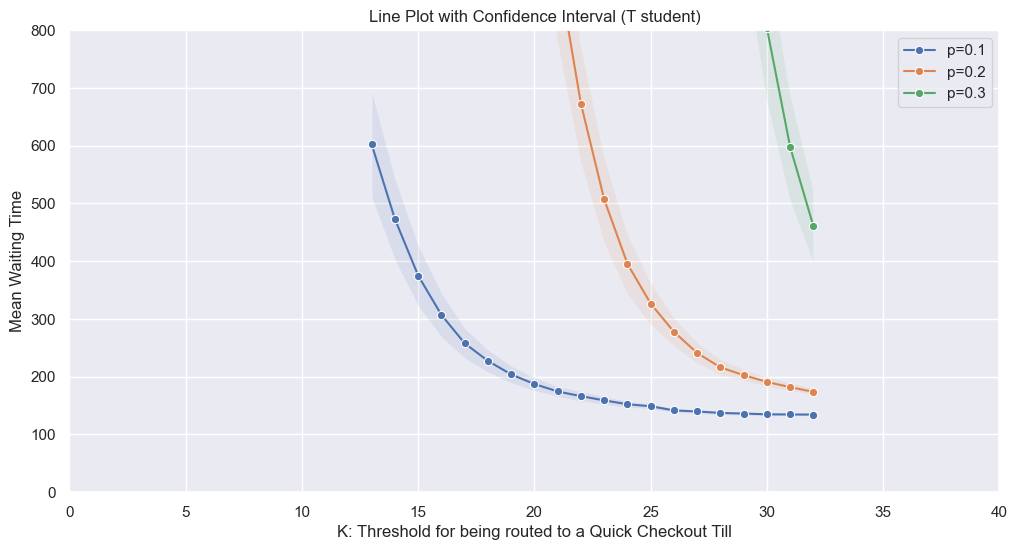

In [69]:
# Single Queue

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

# Ma il mean delle diverse code è uguale al service time del global???
# Provare direttamente a dare tutti i valori a lineplot perché si calcola direttamente il CI
# A questo punto scartare 0.4 e 0.5 e investigare sugli altri ed aumentare K

pi = "W"

for p_ in p:

    y_W = []
    ci_lb = []
    ci_ub = []
    for k in K:
        couple = f"{p_}_{k}"
        
        y_W.append(PI_df[pi][couple]["Q4"].mean())

        ci_lb.append(PI_df[pi][couple]["Q4"].mean() - (1.96 * (PI_df[pi][couple]["Q4"].std() / math.sqrt(n))))
        ci_ub.append(PI_df[pi][couple]["Q4"].mean() + (1.96 * (PI_df[pi][couple]["Q4"].std() / math.sqrt(n))))
        # See also: https://stats.stackexchange.com/questions/12002/how-to-calculate-the-confidence-interval-of-the-mean-of-means

    plt.fill_between(K, ci_lb, ci_ub, alpha=0.1)
    sns.lineplot(x=K, y=y_W, marker='o', label=f"p={p_}")


plt.xlim(0, 40)  # Set the x-axis limits
plt.ylim(0, 800)  # Set the y-axis limits
plt.title('Line Plot with Confidence Interval (T student)')
plt.xlabel('K: Threshold for being routed to a Quick Checkout Till')
plt.ylabel('Mean Waiting Time')

plt.legend()
plt.show()

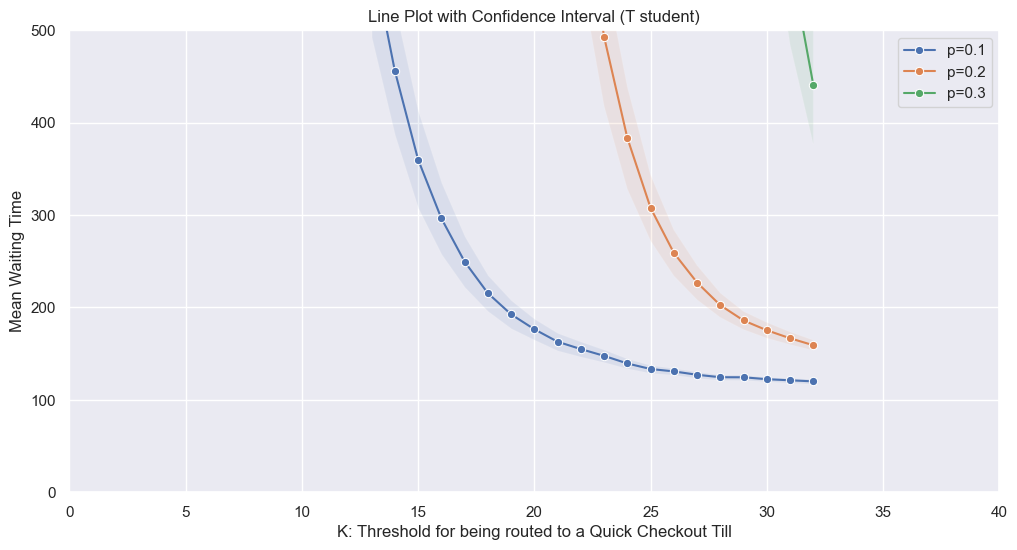

In [67]:
# Single Queue

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

# Ma il mean delle diverse code è uguale al service time del global???
# Provare direttamente a dare tutti i valori a lineplot perché si calcola direttamente il CI
# A questo punto scartare 0.4 e 0.5 e investigare sugli altri ed aumentare K

pi = "W"

for p_ in p:

    y_W = []
    ci_lb = []
    ci_ub = []
    for k in K:
        couple = f"{p_}_{k}"
        
        y_W.append(PI_df[pi][couple]["Q5"].mean())

        ci_lb.append(PI_df[pi][couple]["Q5"].mean() - (1.96 * (PI_df[pi][couple]["Q5"].std() / math.sqrt(n))))
        ci_ub.append(PI_df[pi][couple]["Q5"].mean() + (1.96 * (PI_df[pi][couple]["Q5"].std() / math.sqrt(n))))
        # See also: https://stats.stackexchange.com/questions/12002/how-to-calculate-the-confidence-interval-of-the-mean-of-means

    plt.fill_between(K, ci_lb, ci_ub, alpha=0.1)
    sns.lineplot(x=K, y=y_W, marker='o', label=f"p={p_}")


plt.xlim(0, 40)  # Set the x-axis limits
plt.ylim(0, 500)  # Set the y-axis limits
plt.title('Line Plot with Confidence Interval (T student)')
plt.xlabel('K: Threshold for being routed to a Quick Checkout Till')
plt.ylabel('Mean Waiting Time')

plt.legend()
plt.show()